In [2]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl
import sys
import json
# import tqdm
import torch
from torch.optim  import Adam
from torch.autograd.functional import jacobian
from time import time

from torch.utils.tensorboard import SummaryWriter

from matplotlib          import rcParams
rcParams.update({'figure.dpi': 200})
mpl.rcParams.update({'font.size': 8})
plt.rcParams['figure.dpi'] = 150

## import own functions
sys.path.insert(1, '/STER/silkem/MACE/src/mace')

import src.mace.CSE_0D.dataset      as ds
import src.mace.CSE_0D.train        as tr
import src.mace.neuralODE           as nODE
from src.mace.CSE_0D.loss           import Loss,Loss_analyse
import src.mace.CSE_0D.plotting     as pl
import src.mace.utils        as utils
from src.mace.neuralODE    import Solver
from src.mace.autoencoder import Decoder



%reload_ext autoreload
%autoreload 2

In [3]:
def load_model(loc, meta, epoch, sepr):
    n_dim = 468
    cuda   = False
    DEVICE = torch.device("cuda" if cuda else "cpu")
    model = Solver(p_dim=4,z_dim = meta['z_dim'], n_dim=n_dim, DEVICE = DEVICE)

    if sepr == True:
        file = 'nn/nn'+str(epoch)+'.pt'
    else:
        file = 'nn/nn.pt'

    model.load_state_dict(torch.load(loc+file))
    
    num_params = count_parameters(model)
    print(f'The model has {num_params} trainable parameters')

    return model

def load_all(outloc, dirname, sepr = False, epoch = ''):
    loc   = outloc+dirname+'/'

    ## loading meta file
    with open(loc+'/meta.json', 'r') as f:
        meta=f.read()
    meta  = json.loads(meta)

    ## loading torch model
    model = load_model(loc,meta, epoch, sepr)

    ## loading losses
    if sepr == False:
        trainloss = Loss_analyse()
        trainloss.load(loc, 'train', meta)
        testloss  = Loss_analyse()
        testloss.load(loc, 'test', meta)
        model.set_status(np.load(loc+'train/status.npy'), 'train')
        model.set_status(np.load(loc+'test/status.npy'), 'test')



    if sepr == False:
        return meta, model, trainloss, testloss
    else:
        return meta, model
    

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [84]:
inFile = '/STER/silkem/MACE/input/input_test.txt'
with open(inFile,'r') as f:
    file = f.readlines()
    lines = []
    for line in file:
        lines.append(line.split())

inputfile = {}
for i in range(len(lines)):
    if not len(lines[i]) == 0 and len(lines[i]) > 2:
        # print(test[i])
        inputfile[lines[i][0]] = lines[i][2]
    elif not len(lines[i]) == 0 and len(lines[i]) <= 2:
        print('You forgot to give an input for '+lines[i][0])

## SET PARAMETERS
lr          = float(inputfile['lr'])
tot_epochs  = int(inputfile['tot_epochs'])
nb_epochs   = int(inputfile['nb_epochs'])
ini_epochs  = 5
losstype    = inputfile['losstype']
z_dim       = int(inputfile['z_dim'])
batch_size  = 1
nb_samples  = int(inputfile['nb_samples'])
n_dim       = 468

### Retrieving the min & max values of the dataset

In [79]:
## density
rho_min = np.inf
rho_max = 0
## temperature
T_max = 0
## delta
delta_min = np.inf
delta_max = 0
## Av
Av_min = np.inf
Av_max = 0

dt_max = 0


lens = dict()

for i, path in enumerate(inputdirs):
    print(i, end='\r')

    mod = ds.CSEmod(path)

    ## check the length of the model
    if len(mod) != 135:
        lens[i] = len(mod)
    
    ## check the min and max of the parameters
    ## density
    rho_min_mod = min(mod.get_dens())
    rho_max_mod = max(mod.get_dens())
    if rho_min_mod < rho_min:
        rho_min = rho_min_mod
    if rho_max_mod > rho_max:
        rho_max = rho_max_mod
    ## Av
    Av_min_mod = min(mod.get_Av())
    Av_max_mod = max(mod.get_Av())
    if Av_min_mod < Av_min:
        Av_min = Av_min_mod
    if Av_max_mod > Av_max:
        Av_max = Av_max_mod
    ## temperature
    T_max_mod = max(mod.get_temp())
    if T_max_mod > T_max:
        T_max = T_max_mod
    ## delta
    delta_min_mod = min(mod.get_delta())
    delta_max_mod = max(mod.get_delta())
    if delta_min_mod < delta_min:
        delta_min = delta_min_mod
    if delta_max_mod > delta_max:
        delta_max = delta_max_mod

    ## dt
    dt_max_mod = max(mod.get_dt())
    if dt_max_mod > dt_max:
        dt_max = dt_max_mod

    


In [80]:
## density
print('dens:',rho_min, rho_max)
## temperature
print('temp: 10',T_max)
## delta
print('delta',delta_min, delta_max)
## Av
print('Av',Av_min, Av_max)

print('dt',dt_max)

dens: 0.008223 5009000000.0
temp: 10 1851.0
delta 0.0 0.9999
Av 2.141e-05 1246.0
dt 434800000000.0


In [83]:
meta = {'dens_min': rho_min,
        'dens_max': rho_max,
        'temp_min': 10.,
        'temp_max': T_max,
        'delta_min': delta_min,
        'delta_max': delta_max,
        'Av_min': Av_min,
        'Av_max': Av_max,
        'dt_max': dt_max
        }


json_object = json.dumps(meta, indent=4)
with open("/STER/silkem/MACE/data/minmax.json", "w") as outfile:
    outfile.write(json_object)

### Testing the dataset class

In [37]:
inputdirs = np.loadtxt('data/paths_data_C.txt', dtype=str)

In [73]:
mod = ds.CSEmod(inputdirs[18241])
dt,n,p = mod.split_in_0D()

In [41]:
dt.shape, n.shape, p.shape

((80,), (81, 468), (80, 4))

In [42]:
n = n.reshape(81,468)
n.shape

(81, 468)

In [44]:
n[:-1].shape, n[1:].shape

((80, 468), (80, 468))

In [7]:
mod1 = ds.CSEmod(inputdirs[17982])
mod2 = ds.CSEmod(inputdirs[18241])
len(mod1), len(mod2)

(135, 81)

In [90]:
dt1, n1, p1 = mod1.split_in_0D()
dt2, n2, p2 = mod2.split_in_0D()

In [91]:
dt1.shape, n1.shape, p1.shape, dt2.shape, n2.shape, p2.shape


((134,), (134, 468), (134, 4), (80,), (80, 468), (80, 4))

In [93]:
h = np.concatenate((dt1, dt2), axis=0)
h.shape

(214,)

In [33]:
def generate_random_numbers(n, start, end):
    return np.random.randint(start, end, size=n)

# Generate 10 random integers between 1 and 100
random_numbers = generate_random_numbers(10, 1, 100)

In [68]:
dt, n, p = mod.split_in_0D()
delta = p[:,2]
# norm_delta = utils.normalise(np.log10(p[:,2]), np.log10(1e-100), np.log10(1e-100+0.999))
# norm_dens = utils.normalise(mod.)
# norm_delta

delta



array([7.226e-84, 1.930e-78, 2.241e-73, 1.196e-68, 3.093e-64, 4.071e-60,
       2.854e-56, 1.113e-52, 2.514e-49, 3.414e-46, 2.887e-43, 1.570e-40,
       5.665e-38, 1.393e-35, 2.396e-33, 2.953e-31, 2.664e-29, 1.795e-27,
       9.210e-26, 3.659e-24, 1.144e-22, 2.860e-21, 5.795e-20, 9.643e-19,
       1.335e-17, 1.555e-16, 1.542e-15, 1.315e-14, 9.743e-14, 6.327e-13,
       3.634e-12, 1.861e-11, 8.565e-11, 3.569e-10, 1.355e-09, 4.723e-09,
       1.519e-08, 4.532e-08, 1.262e-07, 3.294e-07, 8.095e-07, 1.881e-06,
       4.147e-06, 8.708e-06, 1.747e-05, 3.356e-05, 6.195e-05, 1.101e-04,
       1.890e-04, 3.137e-04, 5.047e-04, 7.888e-04, 1.200e-03, 1.778e-03,
       2.573e-03, 3.641e-03, 5.045e-03, 6.855e-03, 9.145e-03, 1.199e-02,
       1.548e-02, 1.968e-02, 2.468e-02, 3.053e-02, 3.732e-02, 4.508e-02,
       5.388e-02, 6.373e-02, 7.465e-02, 8.666e-02, 9.974e-02, 1.139e-01,
       1.290e-01, 1.451e-01, 1.622e-01, 1.800e-01, 1.987e-01, 2.180e-01,
       2.380e-01, 2.585e-01, 2.795e-01, 3.008e-01, 

/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot5e-6_v15_T_eps/models/model_2022-12-24h10-24-32/csfrac_smooth.out


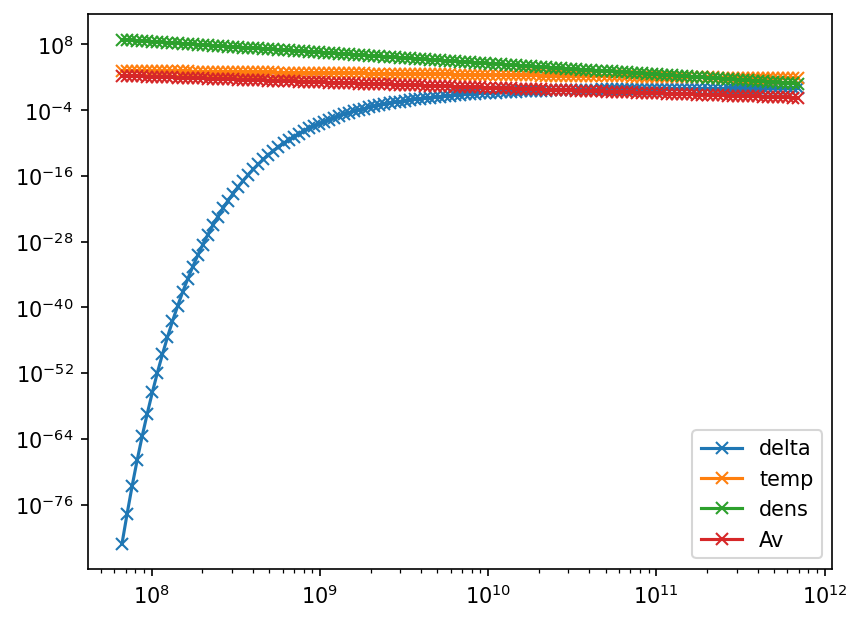

In [116]:
i = 2898-1
mod = ds.CSEmod(inputdirs[i])
print(inputdirs[i])


a=0.5

y = 0.01
# plt.loglog(mod.get_time(), mod.get_delta()+y, '-x', label = 'delta + '+str(y), alpha = a)
y = 1.e-40
# plt.loglog(mod.get_time(), mod.get_delta()+y, '-x', label = 'delta + '+str(y), alpha = a)
plt.loglog(mod.time, mod.get_delta(), '-x', label = 'delta')#, alpha = a)
plt.loglog(mod.get_time(), mod.get_temp(), '-x', label = 'temp')
plt.loglog(mod.get_time(), mod.get_dens(), '-x', label = 'dens')
plt.loglog(mod.get_time(), mod.get_Av(), '-x', label = 'Av')
# plt.loglog(mod.get_time(), mod.get_abs_spec('CO' ),label = 'CO')
# plt.loglog(mod.get_time(), mod.get_abs_spec('H2O'),label = 'H2O')
# plt.loglog(mod.get_time(), mod.get_abs_spec('CH4'),label = 'CH4')
# plt.loglog(mod.get_time(), mod.n[:,-2],label = 'e-')

plt.legend()
plt.show()

### Testing the training

In [12]:
## Set up PyTorch 
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 

lr = 1.e-3
nb_epochs  = 10
ini_epochs = 2
losstype = 'mse_evo_rel_idn'
z_dim = 10
dt_fract = 0.2
batch_size = 1
nb_samples = 100
n_dim = 468

print('------------------------------')
print('      # epochs:', ini_epochs)
print(' learning rate:', lr)
print('# z dimensions:', z_dim)
print('     # samples:', nb_samples)
print('     loss type:', losstype)
print('')


train, test, data_loader, test_loader = ds.get_data(dt_fract=dt_fract,nb_samples=nb_samples, batch_size=batch_size, kwargs=kwargs)

model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, DEVICE = DEVICE)

# num_params = count_parameters(model)
# print(f'The model has {num_params} trainable parameters')

------------------------------
      # epochs: 2
 learning rate: 0.001
# z dimensions: 10
     # samples: 100
     loss type: mse_evo_rel_idn

Dataset:
------------------------------
total # of samples: 100
# training samples: 70
#  testing samples: 30
             ratio: 0.3


In [6]:
norm = {'mse' : 1,
        'rel' : 1,
        'evo' : 1,
        'idn' : 1}

fract = {'mse' : 1, 
         'rel' : 1,
         'evo' : 1,
         'idn' : 1}


## Make loss objects
trainloss = Loss(norm, fract)
testloss  = Loss(norm, fract)

trainloss.set_losstype(losstype)
testloss.set_losstype(losstype)


opt = tr.train(model, lr, data_loader, test_loader, None, end_epochs = ini_epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, plot = False, log = True, show = True)

    


# trainloss.change_norm({'mse' :np.mean(trainloss.get_loss('mse')), # type: ignore
#                        'rel' :np.mean(trainloss.get_loss('rel')), # type: ignore
#                        'evo' :np.mean(trainloss.get_loss('evo'))})   # type: ignore
# testloss.change_norm({'mse' :np.mean(testloss.get_loss('mse')), # type: ignore
#                       'rel' :np.mean(testloss.get_loss('rel')), # type: ignore
#                       'evo' :np.mean(testloss.get_loss('evo'))}) # type: ignore

# tr.train(model, lr, data_loader, test_loader,None, end_epochs = nb_epochs, DEVICE= DEVICE, trainloss=trainloss, testloss=testloss, start_epochs=ini_epochs, plot = False, log = True, show = True)



Model:         
learning rate: 0.001
loss type:     mse_evo_rel_idn

>>> Training model...

	batch 70 / 70

	batch 30 / 30
Epoch 1 complete! 	Average loss train:  2.5495369202110597e+18 	Average loss test:  4.995127305844372e+17

	batch 70 / 70

	batch 30 / 30
Epoch 2 complete! 	Average loss train:  6.281707597735964e+17 	Average loss test:  1.2496709807626893e+17

 	DONE!


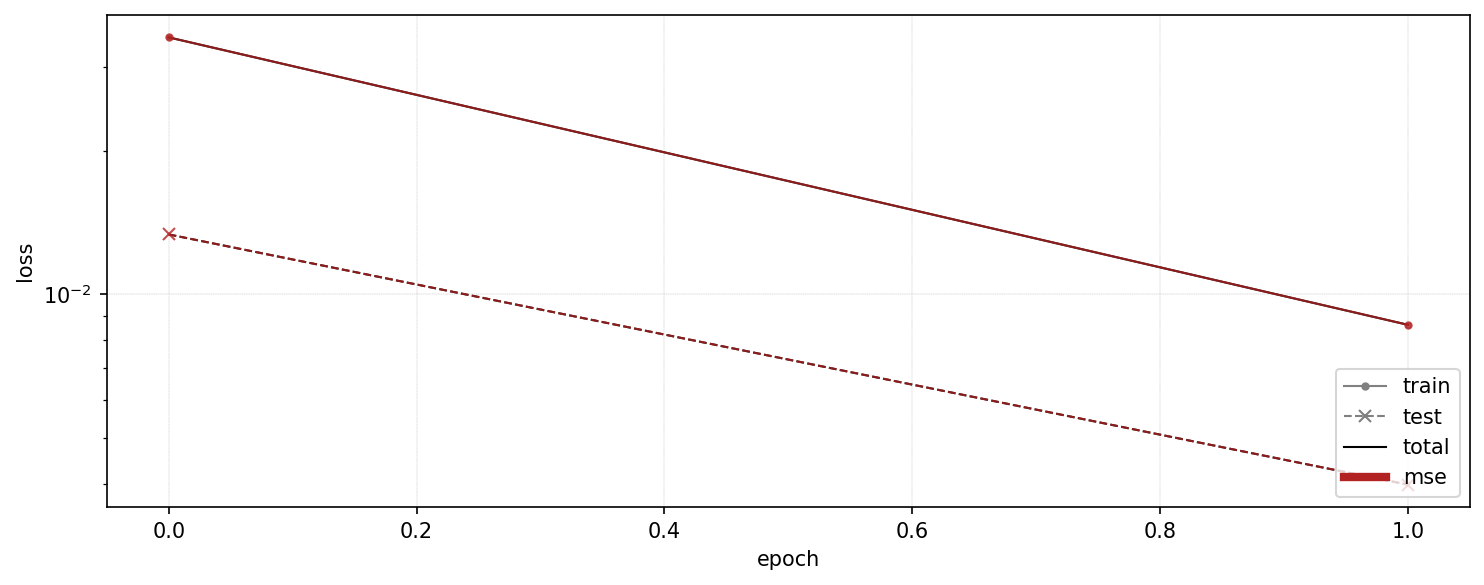

In [6]:
fig = pl.plot_loss(trainloss, testloss, log = True, ylim = False, limits = [1e-2,1e1])

plt.show()

### Testing trained models

In [13]:
outloc  = '/STER/silkem/MACE/models/CSE_0D/'


# dirname = '2023-12-13 09:17:24.777798'    ## mse 
# dirname = '2023-12-13 09:16:22.309926'    ## mse_evo
# dirname = '2023-12-13 09:21:01.223310'    ## mse_rel
# dirname = '2023-12-13 09:21:26.191786'    ## mse_rel_evo

## runs with constant term in lODE
# dirname = "2023-12-13 18:07:09.906353"  ## mse
# dirname = '2023-12-13 18:11:31.009846'  ## mse_evo
# dirname = '2023-12-13 18:13:47.957650'  ## mse_rel
# dirname = '2023-12-13 18:15:20.050262'  ## rel
# dirname = '2023-12-13 18:17:01.439840'  ## mse_rel_evo
# dirname = '2023-12-13 18:28:42.193999'   ## evo

## other learning rates
# dirname = '2023-12-13 18:19:22.522359'  ## lr = 1.e-4       GOOD MODEL
# dirname = '2023-12-13 18:21:02.617224'  ## lr = 1.e-2
dirname = '2023-12-18 10:51:34.569065'  ## lr = 1.e-5

## runs on slurm
# dirname = '2023-12-18 10:59:58.312969'  ## losses scaled

# meta_, model_ = load_all(outloc, dirname, sepr = True, epoch = 2) # type: ignore
meta_, model_, trainloss, testloss = load_all(outloc, dirname, sepr = False, epoch = 2) # type: ignore
print(meta_)
plots_path = outloc+dirname+'/plots/'
utils.makeOutputDir(plots_path)


The model has 76388 trainable parameters
{'nb_samples': 10000, 'lr': 1e-05, 'epochs': 80, 'z_dim': 10, 'dt_fract': 0.147, 'tmax': 434800000000.0, 'train_time': 30720.018476247787, 'overhead': 1.859792947769165, 'samples': 7000, 'cutoff_abs': 1e-20, 'done': 'true', 'norm': {'mse': 1, 'rel': 1, 'evo': 1}, 'fract': {'mse': 100, 'rel': 100, 'evo': 100}, 'losstype': 'mse'}


'/STER/silkem/MACE/models/CSE_0D/2023-12-18 10:51:34.569065/plots/'

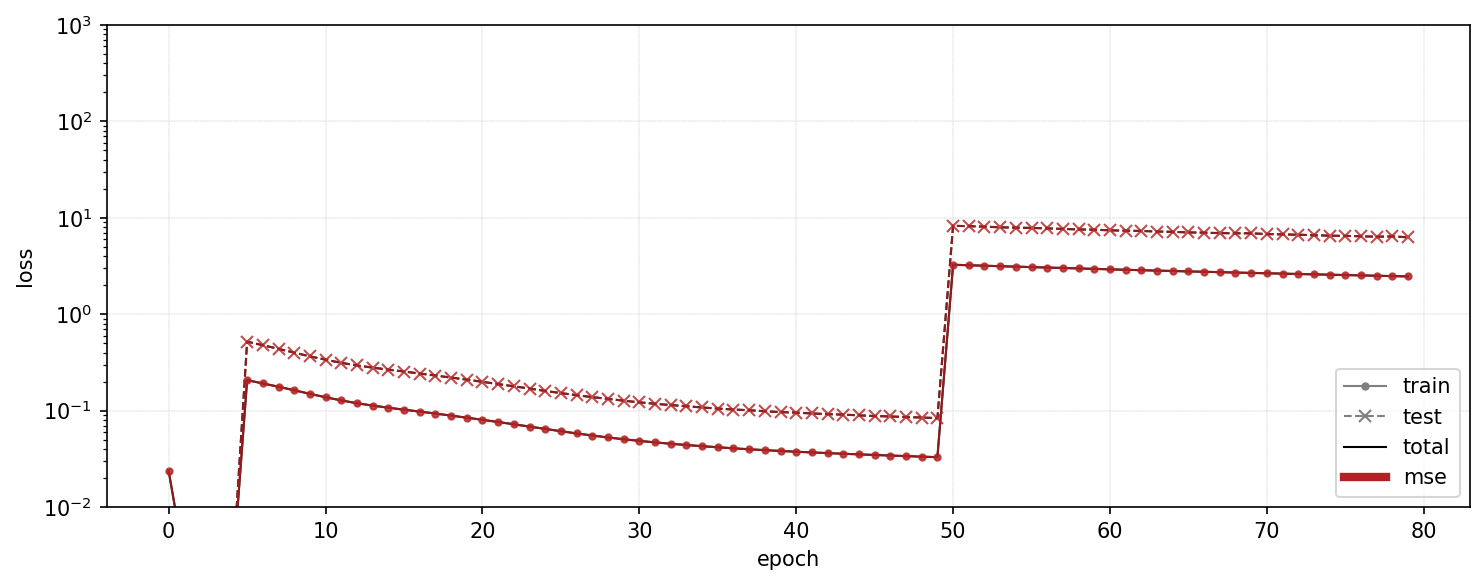

In [14]:
fig = pl.plot_loss(trainloss, testloss, log = True, ylim = True, limits = [1e-2,1e3])#, notest = False)
plt.savefig(plots_path+'loss.png')

['/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-6_v12-5_T_eps/models/model_2022-12-23h12-37-20/csfrac_smooth.out']

>>> Testing model...

Test loss     : 0.009813257137940788
Solving time [s]: 0.005145549774169922
>>> Testing model...


100%|██████████| 133/133 [00:00<00:00, 260.13it/s]


(134,)
(134,)


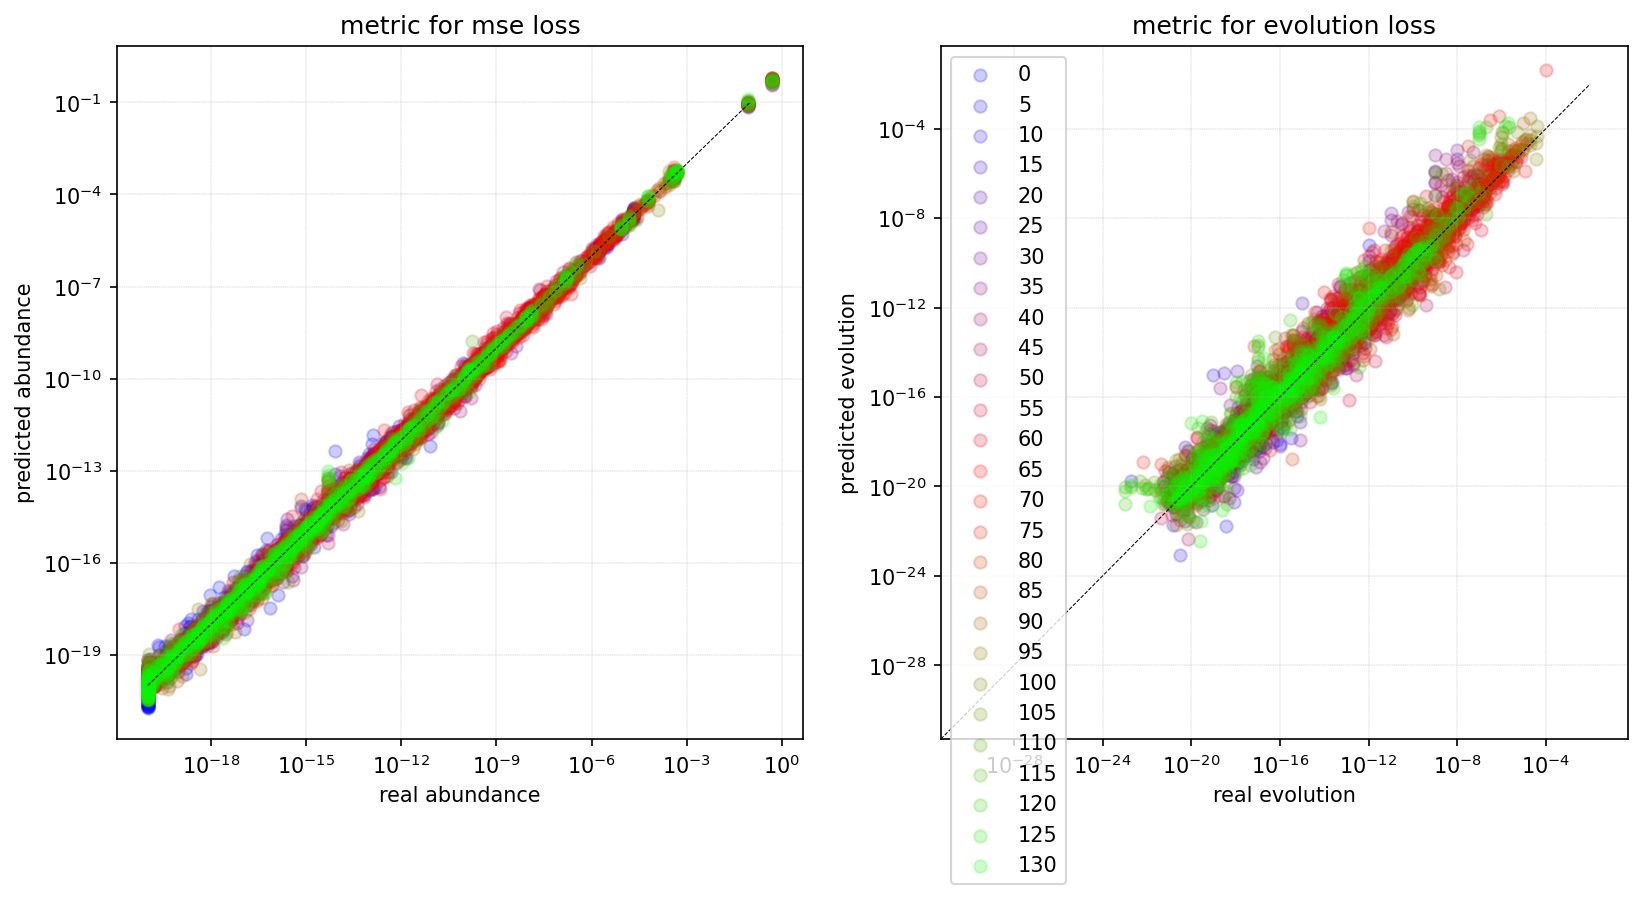

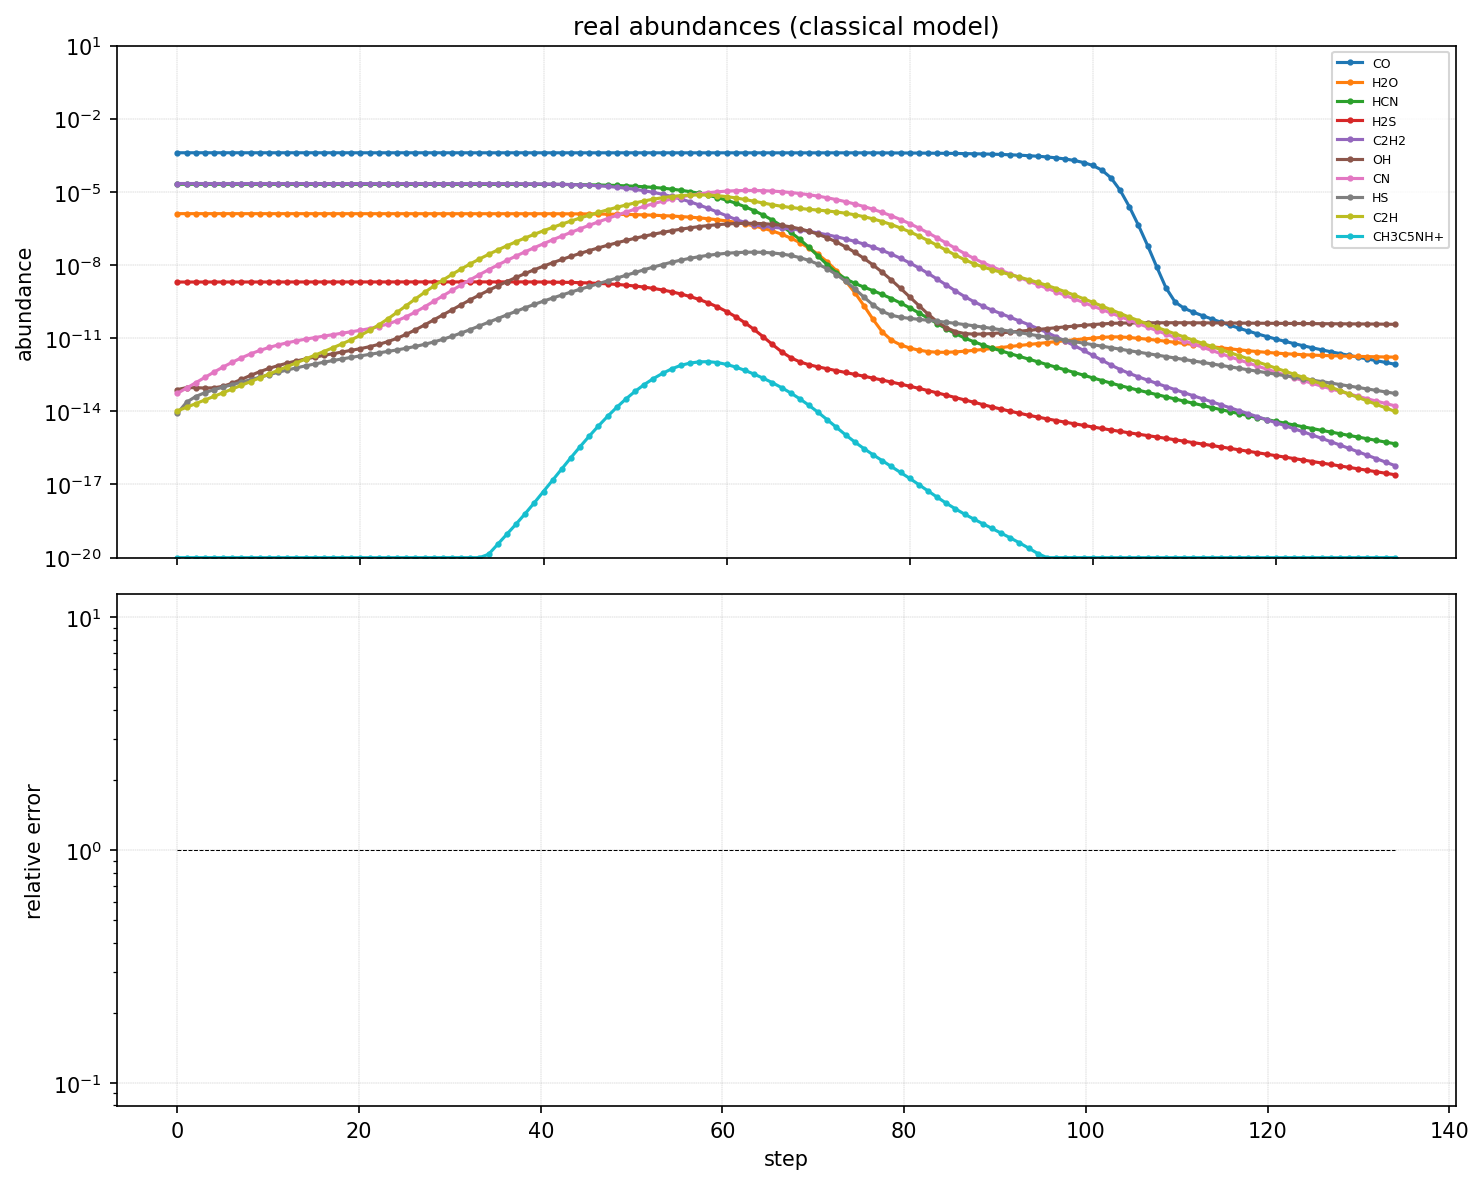

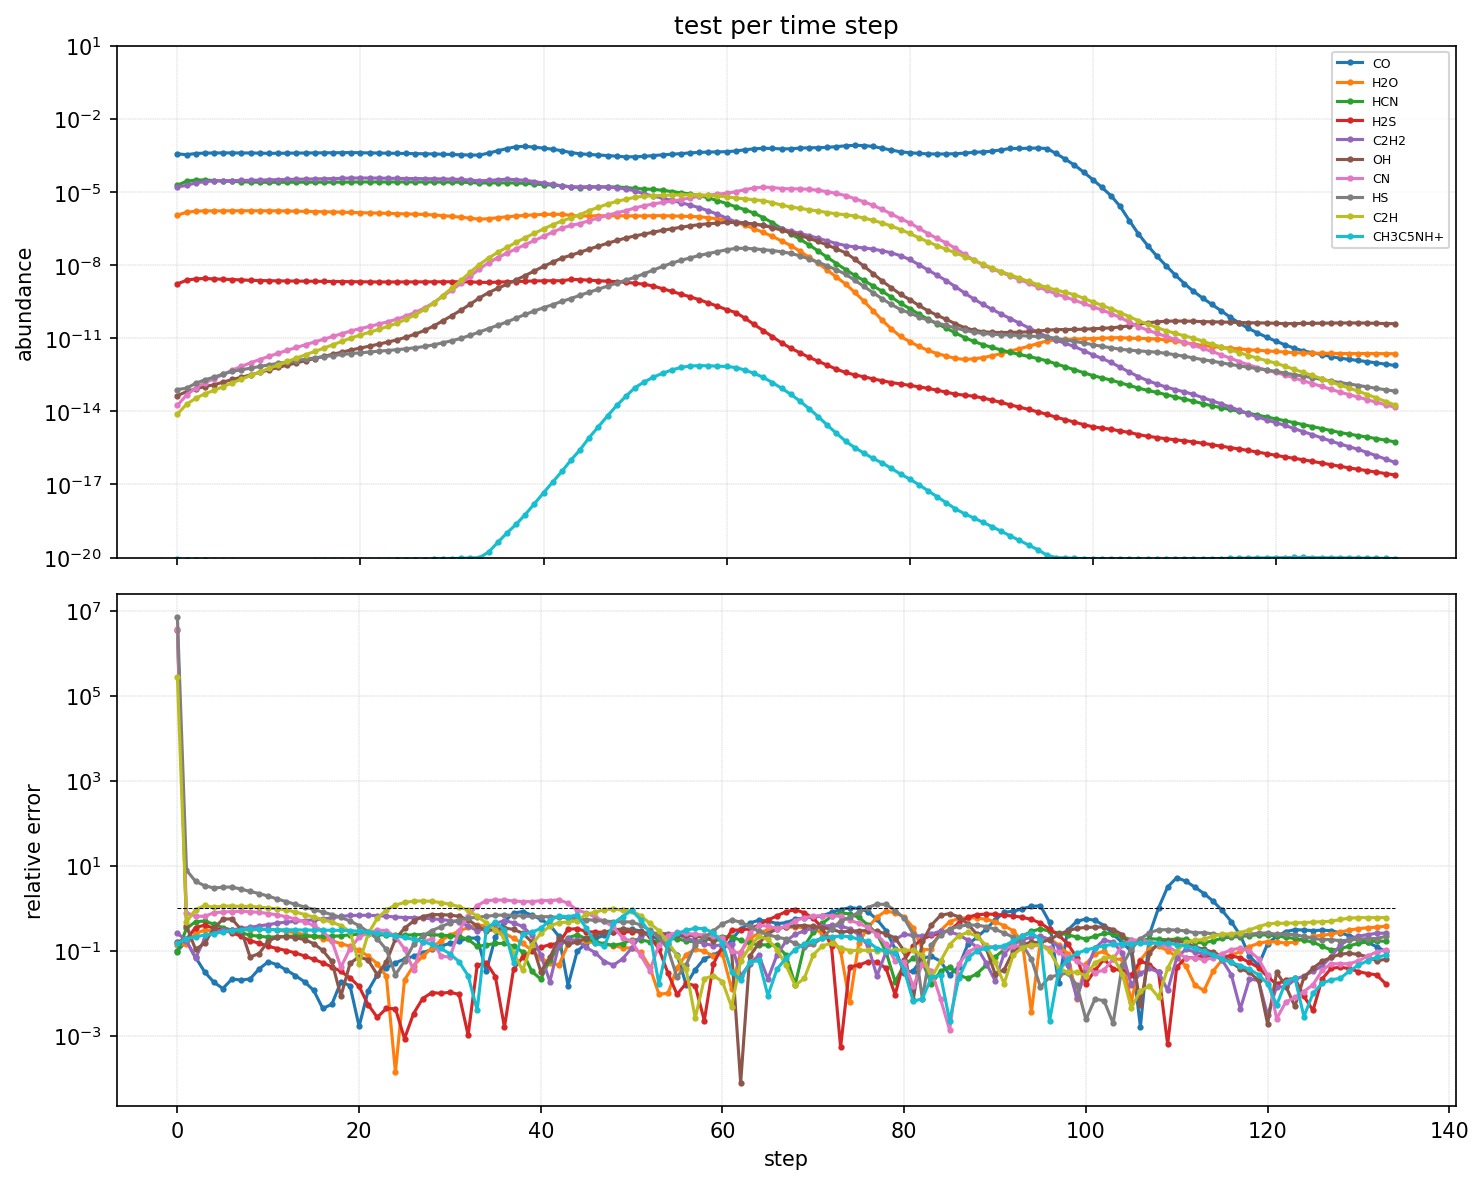

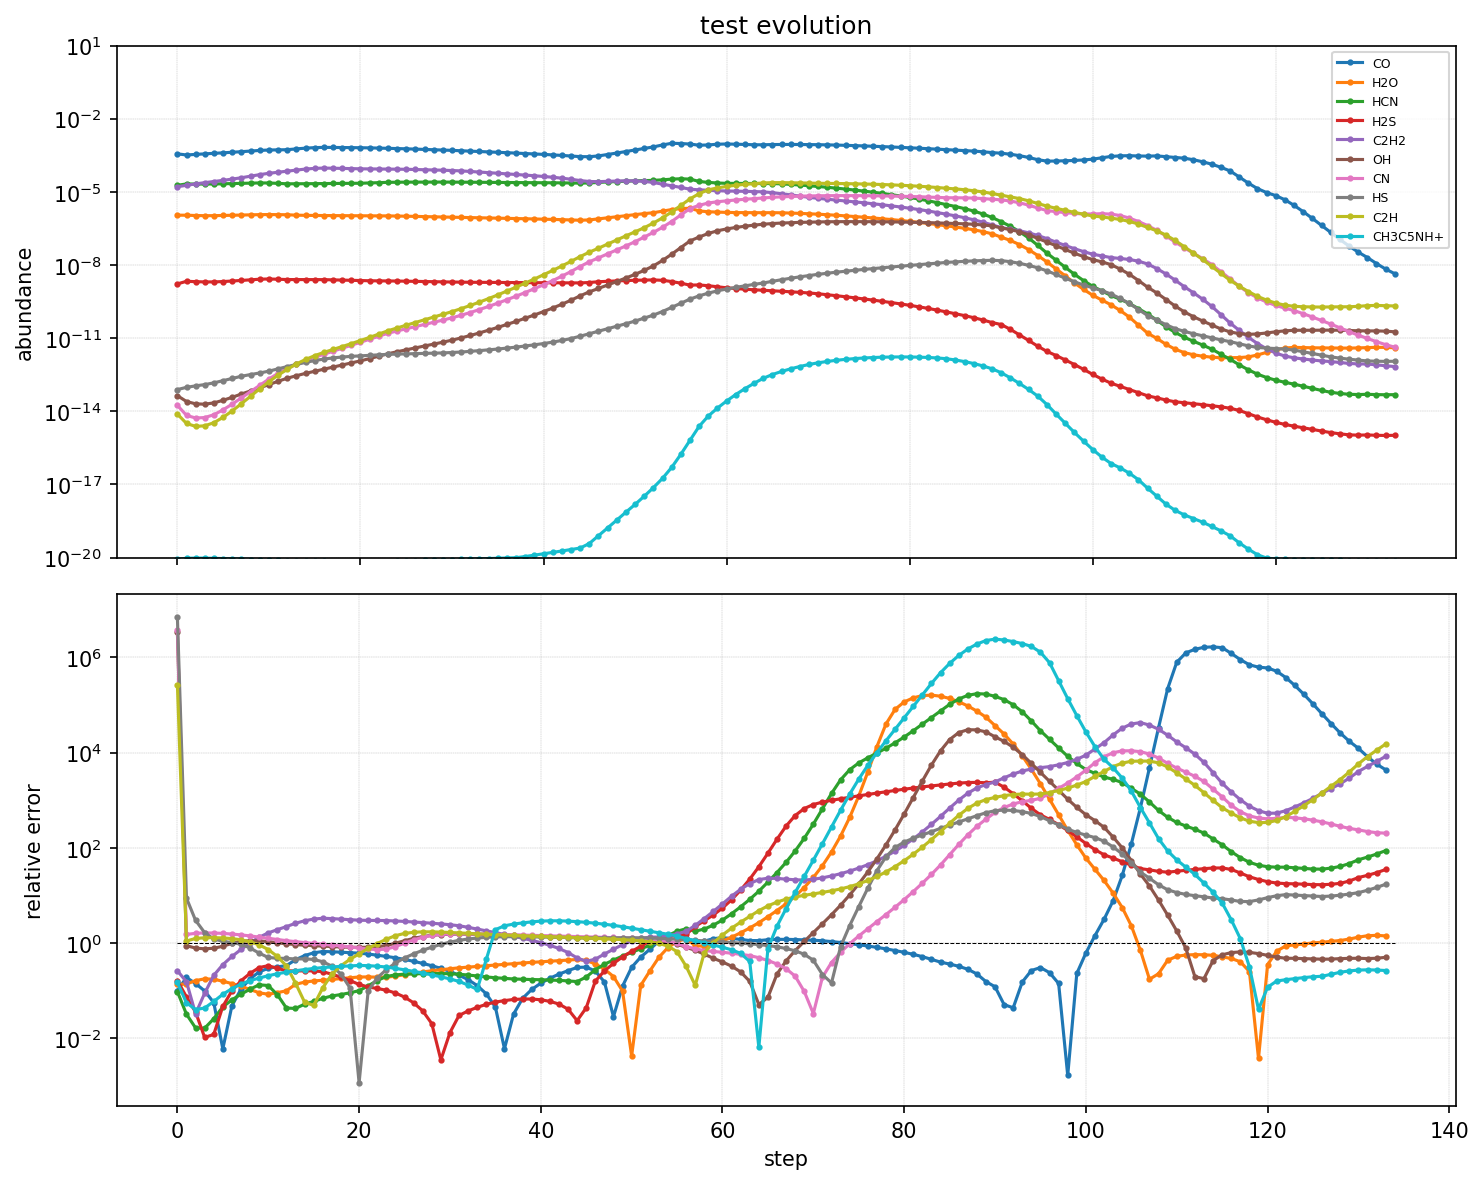

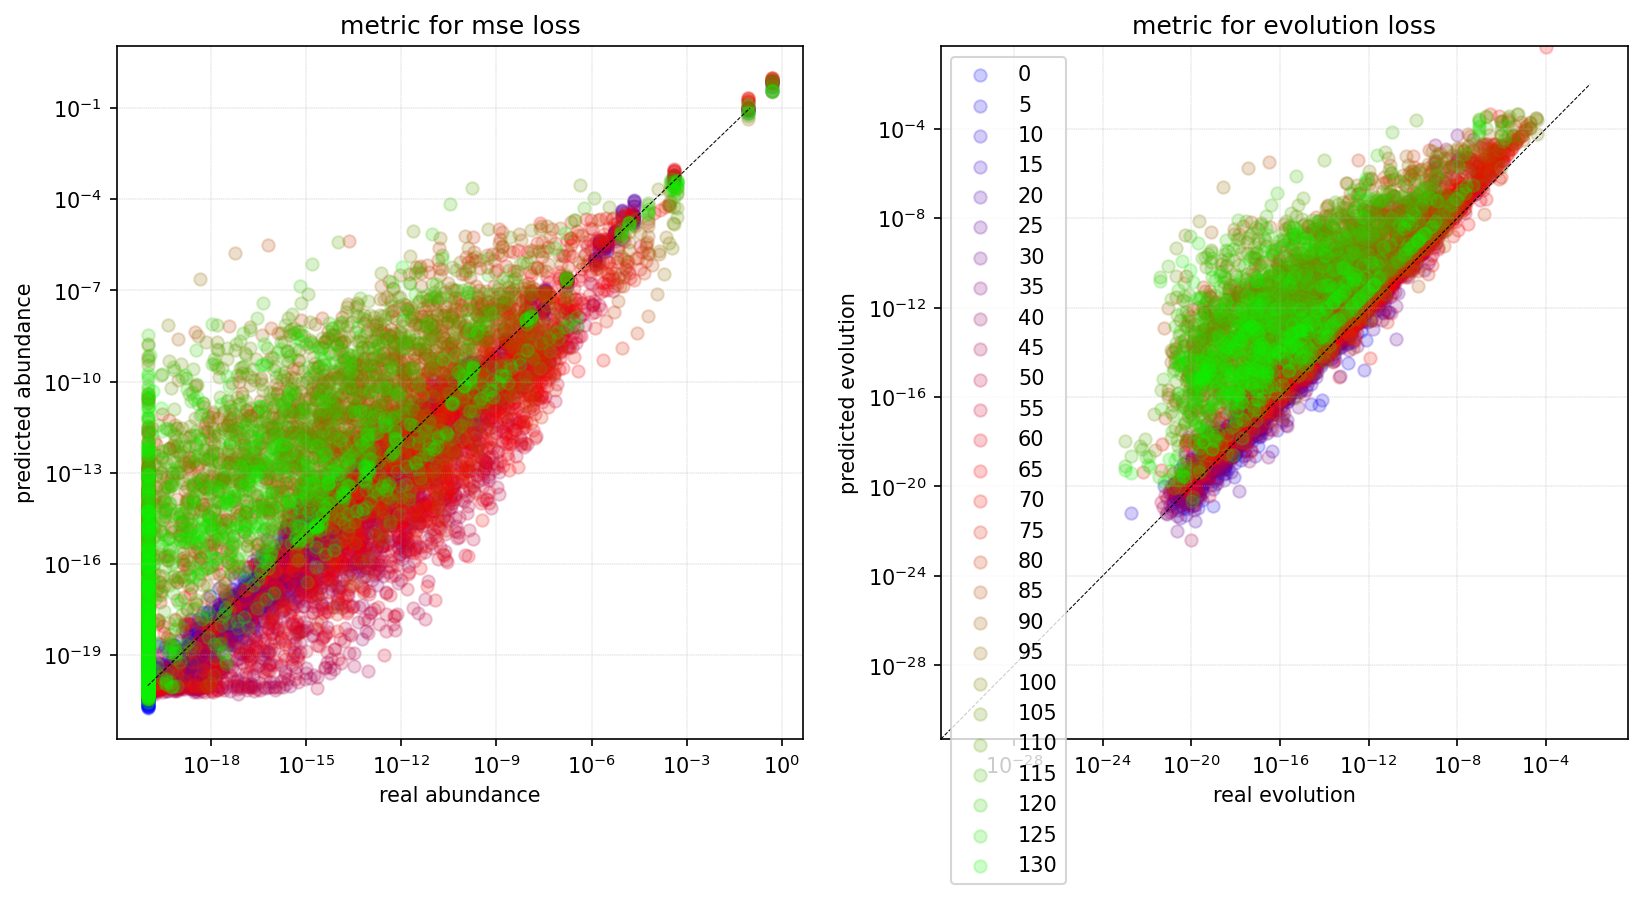

In [17]:

model_testing = model_
specs = ['CO', 'H2O', 'HCN', 'H2S','C2H2', 'OH', 'CN', 'HS', 'C2H', 'CH3C5NH+']
# specs = ['Fe', 'Mg']
# specs = []

input = train.get_test()
print('')
n, n_hat, t, loss, comptime = tr.test(model_testing, input, testloss)
start_idx = 0
n_evo, mace_time = tr.test_evolution(model_testing, input, start_idx=start_idx)

n = ds.get_abs(n)
n_hat = ds.get_abs(n_hat)
n_evo = ds.get_abs(n_evo)


fig, axs = plt.subplots(1,2,figsize=(13,6))
ax1 = axs[0]
ax2 = axs[1]

j=-1
pl.plot_mse(n, n_hat, ax1, 'slateblue', alpha = 0.5, title = "metric for mse loss", j = j)
pl.plot_evo(n, n_hat, ax2, 'darkorange', alpha = 0.5, title = "metric for evolution loss", j = j)
plt.savefig(plots_path+'comparison_per_timestep.png')


## --------------- Classical model ----------------- ##

fig = pl.plot_abs(n,[],plots_path,'real abundances (classical model)', specs)

## --------------- Neural model - per time step ----------------- ##

fig = pl.plot_abs(n,n_hat,plots_path,'test per time step', specs)

## --------------- Neural model - evolution ----------------- ##


fig = pl.plot_abs(n,n_evo,plots_path,'test evolution',specs)

## --

fig, axs = plt.subplots(1,2,figsize=(13,6))
ax1 = axs[0]
ax2 = axs[1]

j=-1
pl.plot_mse(n, n_evo, ax1, 'slateblue', alpha = 0.5, title = "metric for mse loss", j = j)
pl.plot_evo(n, n_evo, ax2, 'darkorange', alpha = 0.5, title = "metric for evolution loss", j = j)
plt.savefig(plots_path+'comparison_evolution.png')


plt.show()


### Testing jacobian

In [174]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, DEVICE = DEVICE)

z = torch.randn(134,10, requires_grad=True)
M = np.load('/STER/silkem/ChemTorch/rates/M_rate16.npy')

M = torch.from_numpy(M).to_sparse()



In [176]:
A = model.g.A
B = model.g.B
C = model.g.C
jac_D = jacobian(model.decoder,z, strategy='forward-mode', vectorize=True).view(468,134,134,-1)

In [152]:
tic = time()
ode = C + torch.einsum("ij, bj -> bi", A, z) + torch.einsum("ijk, bj, bk -> bi", B, z, z) 
toc = time()
print('time:', toc-tic)

time: 0.0006093978881835938


In [9]:
Aode = torch.einsum("ij, bj -> bi", A, z)
Aode.shape

torch.Size([134, 10])

In [148]:
Bode = torch.einsum("ijk, bj, bk -> bi", B, z, z)
Bode.shape

torch.Size([134, 10])

In [145]:
(z.unsqueeze(-1)* z.unsqueeze(1) ).shape

torch.Size([134, 10, 10])

In [154]:
tic = time()
Aode = z@A
Bode = (B @ (z.unsqueeze(-1) * z.unsqueeze(1)).T).sum()
toc = time()
print('time:', toc-tic)

print(C.shape , Aode.shape, Bode.shape)

ode = C+Aode+Bode



time: 0.0010347366333007812
torch.Size([10]) torch.Size([134, 10]) torch.Size([])


In [169]:

tic = time()
L0 = torch.einsum("NZ , Nbci , i   -> bcZ  ", M , jac_D , C)
L1 = torch.einsum("NZ , Nbci , ij  -> bcZj ", M , jac_D , A)
L2 = torch.einsum("NZ , Nbci , ijk -> bcZjk", M , jac_D , B)
toc = time()

print(toc-tic)
L0.shape, L1.shape, L2.shape

1.018272876739502


(torch.Size([134, 134, 14]),
 torch.Size([134, 134, 14, 10]),
 torch.Size([134, 134, 14, 10, 10]))

In [87]:
C.shape, A.shape, B.shape, z.shape, jac_D.shape, M.shape

(torch.Size([10]),
 torch.Size([10, 10]),
 torch.Size([10, 10, 10]),
 torch.Size([134, 10]),
 torch.Size([468, 134, 134, 10]),
 torch.Size([468, 14]))

In [177]:
tic = time()
L_0 = (jac_D @ C).T @ M
toc = time()
L_0.shape, toc-tic

(torch.Size([134, 134, 14]), 0.6680154800415039)

In [171]:
(L0-L_0).sum()

tensor(3.1974e-14, grad_fn=<SumBackward0>)

In [178]:
tic = time()
L_1 = (jac_D @ model.g.A).T @ M
toc = time()
L_1.shape, toc-tic

(torch.Size([10, 134, 134, 14]), 5.053350448608398)

In [173]:
(L1-L_1.view(134,134,-1,10)).sum()

tensor(0., grad_fn=<SumBackward0>)

In [193]:
L2 = (jac_D @ model.g.B)

RuntimeError: The size of tensor a (134) must match the size of tensor b (10) at non-singleton dimension 1

In [191]:
jac_D.shape, model.g.B.shape

(torch.Size([468, 134, 134, 10]), torch.Size([10, 10, 10]))

### Testing gradient loss

In [ ]:
model = nODE.Solver(p_dim=4,z_dim = z_dim, n_dim=n_dim, DEVICE = DEVICE)

z = torch.randn(134,10, requires_grad=True)
M = np.load('/STER/silkem/ChemTorch/rates/M_rate16.npy')

M = torch.from_numpy(M).to_sparse()



In [ ]:
A = model.g.A
B = model.g.B
C = model.g.C
jac_D = jacobian(model.decoder,z, strategy='forward-mode', vectorize=True).view(468,134,134,-1)

In [64]:
## import own functions
sys.path.insert(1, '/STER/silkem/ChemTorch/src/')
import ode.acodes   as odes
import rates    as rates
import input    as input

In [65]:
data = ds.CSEdata( nb_samples=10000, dt_fract=dt_fract)

i = 0
path = data.path[i]

n,p,dt = data[i]

path

'/lhome/silkem/CHEM/Output_nov2022/20211014_gridC_Mdot1e-8_v10_T_eps/models/model_2022-12-23h17-45-41/csfrac_smooth.out'

In [66]:
mod = ds.CSEmod(path)

In [67]:
dt_or, n_or, p_or = mod.split_in_0D()
n_or = np.clip(n_or, 1e-20, None)

In [68]:
n = ds.get_abs(n)
p = ds.get_phys(p, data)

In [69]:
(p-p_or).sum()

tensor(-1.1457e-08)

In [75]:
print(np.abs(n-n_or))

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         3.9968e-15],
        [1.3764e-21, 4.5438e-28, 2.7610e-29,  ..., 0.0000e+00, 8.6027e-23,
         3.9968e-15],
        [4.8704e-21, 6.5633e-28, 3.9443e-30,  ..., 0.0000e+00, 1.3235e-22,
         3.9968e-15],
        ...,
        [6.5052e-19, 1.6941e-21, 1.8933e-29,  ..., 0.0000e+00, 0.0000e+00,
         2.7200e-15],
        [6.5052e-19, 1.2705e-20, 1.8933e-29,  ..., 0.0000e+00, 2.3852e-18,
         2.7200e-15],
        [3.2526e-19, 8.4703e-22, 1.8933e-29,  ..., 0.0000e+00, 1.9516e-18,
         2.7200e-15]])


In [71]:
n

tensor([[1.0000e-20, 1.0000e-20, 1.0000e-20,  ..., 1.0000e-20, 1.0000e-20,
         5.0000e-01],
        [5.1950e-07, 2.9690e-13, 5.2490e-15,  ..., 1.0000e-20, 3.1180e-08,
         5.0000e-01],
        [1.1290e-06, 3.4390e-13, 6.2880e-15,  ..., 1.0000e-20, 5.9860e-08,
         5.0000e-01],
        ...,
        [3.4320e-04, 3.9550e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1790e-04,
         4.9980e-01],
        [3.4390e-04, 4.3380e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1830e-04,
         4.9980e-01],
        [3.4470e-04, 4.7510e-06, 1.2830e-14,  ..., 1.0000e-20, 5.1880e-04,
         4.9980e-01]])

In [72]:
n_or

array([[1.000e-20, 1.000e-20, 1.000e-20, ..., 1.000e-20, 1.000e-20,
        5.000e-01],
       [5.195e-07, 2.969e-13, 5.249e-15, ..., 1.000e-20, 3.118e-08,
        5.000e-01],
       [1.129e-06, 3.439e-13, 6.288e-15, ..., 1.000e-20, 5.986e-08,
        5.000e-01],
       ...,
       [3.432e-04, 3.955e-06, 1.283e-14, ..., 1.000e-20, 5.179e-04,
        4.998e-01],
       [3.439e-04, 4.338e-06, 1.283e-14, ..., 1.000e-20, 5.183e-04,
        4.998e-01],
       [3.447e-04, 4.751e-06, 1.283e-14, ..., 1.000e-20, 5.188e-04,
        4.998e-01]])